<a href="https://colab.research.google.com/github/nkeseeyo/datasets-nk/blob/main/datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment & Folder Setup

This cell creates three folders data, results, and models to organise the project files. It ensures clean storage for datasets, output results, and trained models, preventing file-path errors during execution.

In [ ]:
import os
os.makedirs("data", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the BUSI dataset

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ultra = datagen.flow_from_directory(
    "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Ultrasound/Dataset_BUSI_with_GT",
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_ultra = datagen.flow_from_directory(
    "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Ultrasound/Dataset_BUSI_with_GT",
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Display the first batch of training data
images, labels = next(train_ultra)
print("Shape of the first batch of images:", images.shape)
print("Shape of the first batch of labels:", labels.shape)

Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.
Shape of the first batch of images: (32, 128, 128, 3)
Shape of the first batch of labels: (32,)


In [ ]:
!ls "/content/drive/MyDrive/datasets/DATASETSWORK/"

Code


In [ ]:
!ls "/content/drive/MyDrive/datasets/DATASETSWORK/code"

ls: cannot access '/content/drive/MyDrive/datasets/DATASETSWORK/code': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/datasets"


DATASETSWORK


In [ ]:
!ls "/content/drive/MyDrive/datasets/DATASETSWORK"


Code


In [ ]:
!ls "/content/drive/MyDrive/datasets/DATASETSWORK/Code"


C92550.ipynb  data  dataset  models  requirements.txt  results


In [ ]:
!ls "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset"


'Breast Cancer YasserH'  'MIAS Mammography Dataset'
'Breast Ultrasound'	 'Wisconsin Diagnostic'


In [ ]:
!ls "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Ultrasound"


Dataset_BUSI_with_GT


In [ ]:
!ls "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Ultrasound/Dataset_BUSI_with_GT"


benign	malignant  normal


## Install Dependencies

This cell displays the active Python interpreter path and installs all essential librariesvjoblib, pandas, numpy, scikit-learn, imbalanced-learn, shap, matplotlib, seaborn, kaggle, and tensorflow ensuring every dependency required for data processing and model training is available.

In [ ]:
import sys
print(sys.executable)
!{sys.executable} -m pip install joblib pandas numpy scikit-learn imbalanced-learn shap matplotlib seaborn kaggle tensorflow

/usr/bin/python3


## Imports & Helper Functions

This cell imports essential libraries, defines preprocessing, evaluation, and explainability functions, and sets a random seed. It prepares reusable utilities for model training, data cleaning, performance measurement, and SHAP-based feature importance visualisation in breast cancer classification tasks.

In [ ]:
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, Dict, Any
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc, classification_report
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

try:
    import shap
    shap_installed = True
except:
    shap_installed = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def ensure_binary(y: pd.Series) -> pd.Series:
    """Map common breast-cancer labels to 0/1 (0=benign, 1=malignant)."""
    y2 = y.copy()
    # Common label names
    mapping_candidates = [
        {'M':1, 'B':0, 'benign':0, 'malignant':1, 'Benign':0, 'Malignant':1},
        {'1':1, '0':0}, {1:1, 0:0}, {'yes':1, 'no':0}, {'Y':1, 'N':0}
    ]
    if y2.dtype == 'O':
        y2 = y2.str.strip()
    for mp in mapping_candidates:
        try:
            return y2.map(mp).astype(int)
        except Exception:
            pass
    if pd.api.types.is_numeric_dtype(y2):
        return (y2.astype(float) > 0).astype(int)
    classes = {cls:i for i, cls in enumerate(sorted(y2.unique()))}
    return y2.map(classes).astype(int)

def basic_numeric_categoricals(X: pd.DataFrame) -> Tuple[list, list]:
    """Split columns into numeric/categorical for preprocessing."""
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    return num_cols, cat_cols

def build_preprocessor(X: pd.DataFrame, scale: bool=True) -> ColumnTransformer:
    num_cols, cat_cols = basic_numeric_categoricals(X)
    num_tf = []
    if len(num_cols):
        num_tf = [('num_impute', SimpleImputer(strategy='median'), num_cols)]
        if scale:
            num_tf.append(('num_scale', StandardScaler(), num_cols))
    cat_tf = []
    if len(cat_cols):
        cat_tf = [('cat_impute', SimpleImputer(strategy='most_frequent'), cat_cols)]

    transformers = []
    transformers.extend([t for t in num_tf])
    transformers.extend([t for t in cat_tf])
    if not transformers:
        raise ValueError("No columns found to preprocess.")
    return ColumnTransformer(transformers=transformers, remainder='drop')

def evaluate_and_plot(y_true, y_prob, y_pred, model_name, dataset_name, out_dir="results"):
    """Compute metrics, save CM & ROC plots, return metrics dict."""
    os.makedirs(out_dir, exist_ok=True)
    metrics = {
        "dataset": dataset_name,
        "model": model_name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except:
        roc_auc = np.nan
    metrics["roc_auc"] = roc_auc

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig_cm, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_title(f"Confusion Matrix: {model_name} on {dataset_name}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    cm_path = f"{out_dir}/CM_{dataset_name}_{model_name}.png".replace(" ", "_")
    fig_cm.savefig(cm_path, bbox_inches="tight", dpi=150)
    plt.show()
    plt.close(fig_cm)

    # ROC curve
    if not np.isnan(roc_auc):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        fig_roc, ax = plt.subplots()
        ax.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
        ax.plot([0,1], [0,1], linestyle='--')
        ax.set_title(f"ROC: {model_name} on {dataset_name}")
        ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
        ax.legend()
        roc_path = f"{out_dir}/ROC_{dataset_name}_{model_name}.png".replace(" ", "_")
        fig_roc.savefig(roc_path, bbox_inches="tight", dpi=150)
        plt.show()
        plt.close(fig_roc)

    # Classification report text
    report_txt = classification_report(y_true, y_pred, digits=3)
    with open(f"{out_dir}/REPORT_{dataset_name}_{model_name}.txt".replace(" ", "_"), "w") as f:
        f.write(report_txt)

    return metrics

def maybe_shap_summary(fitted_pipeline, X_tr, dataset_name, model_name, out_dir="results"):
    """Optional SHAP summary for RF/LR if shap is installed."""
    if not shap_installed:
        return
    # Extract final estimator
    try:
        final_est = fitted_pipeline.named_steps['clf']
    except:
        # imblearn Pipeline naming
        final_est = fitted_pipeline.named_steps.get('clf', None)
    if final_est is None:
        return
    if isinstance(final_est, (RandomForestClassifier, LogisticRegression)):
        # Get processed X for SHAP
        try:
            preproc = fitted_pipeline.named_steps['preproc']
            X_proc = preproc.transform(X_tr)
        except:
            X_proc = X_tr.values
        explainer = shap.Explainer(final_est, X_proc)
        shap_values = explainer(X_proc[:100])  # subsample for speed
        plt.figure()
        shap.plots.beeswarm(shap_values, show=False, max_display=15)
        p = f"{out_dir}/SHAP_{dataset_name}_{model_name}.png".replace(" ", "_")
        plt.title(f"SHAP Summary: {model_name} on {dataset_name}")
        plt.savefig(p, bbox_inches='tight', dpi=150)
        plt.show()
        plt.close()

## Dataset Loaders
This cell defines dataset loader functions for various breast cancer datasets. It handles tabular data (Kaggle and Wisconsin) and image data (BUSI and MIAS) using preprocessing, directory-based loading, and Keras ImageDataGenerator for model-ready input.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer as sk_breast
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Utility
def ensure_binary(y: pd.Series):
    """Convert string labels like 'Benign'/'Malignant' into 0/1 numeric."""
    mapping = {'B':0, 'M':1, 'benign':0, 'malignant':1, 'normal':0, 'Benign':0, 'Malignant':1, 'Normal':0}
    if y.dtype == 'O':
        return y.map(mapping).astype(int)
    return y.astype(int)


# 1. Kaggle Breast Cancer YasserH
def load_dataset_yasserh(path="/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Cancer YasserH/breast-cancer.csv):
    df = pd.read_csv(path)
    target_col = None
    for col in ['diagnosis','Class','target','Outcome']:
        if col in df.columns:
            target_col = col
            break
    if target_col is None:
        target_col = df.columns[-1]
    y = ensure_binary(df[target_col])
    X = df.drop(columns=[target_col])
    for c in ['id','ID','Unnamed: 32']:
        if c in X.columns:
            X = X.drop(columns=[c])
    return X, y


# 2. Wisconsin Diagnostic Dataset
def load_dataset_wisconsin(path="dataset/Wisconsin Diagnostic/data.csv"):
    df = pd.read_csv(path)
    # Usually columns: ID, diagnosis, 30 features
    if 'diagnosis' in df.columns:
        y = ensure_binary(df['diagnosis'])
        X = df.drop(columns=['diagnosis'])
    else:
        y = ensure_binary(df.iloc[:, 1])
        X = df.drop(df.columns[[0, 1]], axis=1)
    return X, y


# 3. Breast Ultrasound Dataset (BUSI)
def load_dataset_ultrasound(path="dataset/Breast Ultrasound/Dataset_BUSI_with_GT", img_size=(128,128), batch_size=32):
    """
    Loads BUSI ultrasound images from three folders: benign, malignant, normal.
    Returns ImageDataGenerator flow for training/testing.
    """
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = datagen.flow_from_directory(
        path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )
    val_gen = datagen.flow_from_directory(
        path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )
    return train_gen, val_gen


# 4. MIAS Mammography Dataset
def load_dataset_mias(path="dataset/MIAS Mammography Dataset/all-mias", img_size=(128,128), batch_size=32):
    """
    Loads MIAS images (converted to PNG/JPG/PGM) using ImageDataGenerator.
    Expects folders containing labeled subdirectories or filenames with labels.
    If only one folder exists, you can create subfolders manually by label.
    """
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # If the dataset has subfolders (e.g., benign/malignant)
    if any(os.path.isdir(os.path.join(path, d)) for d in os.listdir(path)):
        train_gen = datagen.flow_from_directory(
            path,
            target_size=img_size,
            batch_size=batch_size,
            class_mode='binary',
            subset='training'
        )
        val_gen = datagen.flow_from_directory(
            path,
            target_size=img_size,
            batch_size=batch_size,
            class_mode='binary',
            subset='validation'
        )
    else:
        raise ValueError("MIAS dataset needs subfolders (benign/malignant) or labeled filenames.")
    return train_gen, val_gen


# 5. Sklearn Built-In Dataset (optional for comparison)
def load_dataset_sklearn():
    data = sk_breast()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target)
    return X, y

## Define the 4 Algorithms
This cell defines a function that returns four machine learning models Random Forest, SVM, KNN, and Logistic Regression each configured with balanced class weights and tuned parameters for reliable breast cancer classification.

In [ ]:
def get_models() -> Dict[str, Any]:
    models = {
        "RandomForest": RandomForestClassifier(
            n_estimators=300, random_state=RANDOM_STATE, class_weight='balanced'
        ),
        "SVM": SVC(
            kernel='rbf', probability=True, random_state=RANDOM_STATE, class_weight='balanced'
        ),
        "KNN": KNeighborsClassifier(n_neighbors=7),
        "LogisticRegression": LogisticRegression(
            max_iter=2000, random_state=RANDOM_STATE, class_weight='balanced'
        )
    }
    return models

## Unified Train/Eval Loop (Produces 16 Results)
This cell defines a function that trains all machine learning models on one dataset. It splits data, applies preprocessing, handles imbalance with SMOTE, evaluates performance using multiple metrics, saves visual results, and exports trained models and CSV summaries.

In [ ]:
def train_one_dataset(X, y, dataset_name: str, models: Dict[str, Any], out_dir="results") -> pd.DataFrame:
    results = []
    os.makedirs(out_dir, exist_ok=True)

    # Split once for fair comparison
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

    # Preprocessor (scale beneficial for SVM/KNN/LR; ok for RF too)
    preproc = build_preprocessor(X_tr, scale=True)

    for model_name, clf in models.items():
        # Imbalanced pipeline: Preprocess -> SMOTE -> Classifier
        pipe = ImbPipeline(steps=[
            ('preproc', preproc),
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('clf', clf)
        ])

        # Fit
        pipe.fit(X_tr, y_tr)

        # Predict proba and labels
        try:
            y_prob = pipe.predict_proba(X_te)[:,1]
        except:
            # For models without predict_proba
            y_prob = pipe.decision_function(X_te)
            # scale to 0-1
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min() + 1e-8)
        y_pred = pipe.predict(X_te)

        # Evaluate + plots
        metrics = evaluate_and_plot(y_te, y_prob, y_pred, model_name, dataset_name, out_dir=out_dir)
        results.append(metrics)

        maybe_shap_summary(pipe, X_tr, dataset_name, model_name, out_dir=out_dir)

        # Save model
        joblib.dump(pipe, f"models/{dataset_name}_{model_name}.joblib".replace(" ", "_"))

    df_res = pd.DataFrame(results)
    csv_path = f"{out_dir}/ALL_METRICS.csv"
    if os.path.exists(csv_path):
        existing = pd.read_csv(csv_path)
        pd.concat([existing, df_res], ignore_index=True).to_csv(csv_path, index=False)
    else:
        df_res.to_csv(csv_path, index=False)

    df_res.to_csv(f"{out_dir}/METRICS_{dataset_name}.csv".replace(" ", "_"), index=False)
    return df_res

## Run All 4 Datasets × 4 Models
This cell sequentially trains models on all datasets. It runs tabular datasets through machine learning pipelines, loads image datasets for CNN preparation, merges tabular results into one summary file, and confirms readiness for deep learning training.

Loaded 4 models successfully.


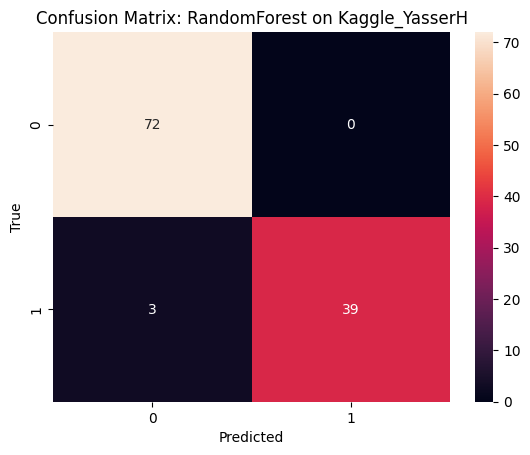

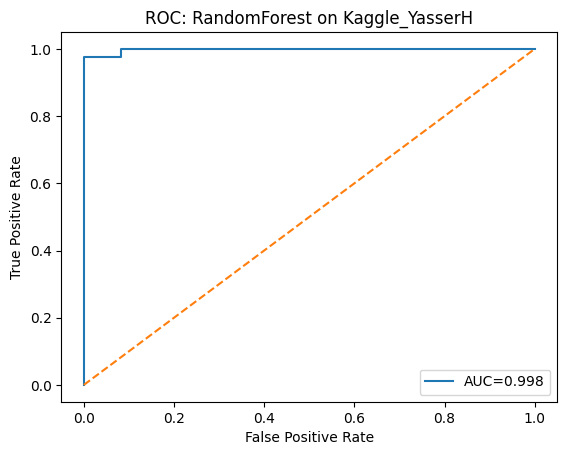

SHAP skipped for Kaggle_YasserH-RandomForest: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!


<Figure size 640x480 with 0 Axes>

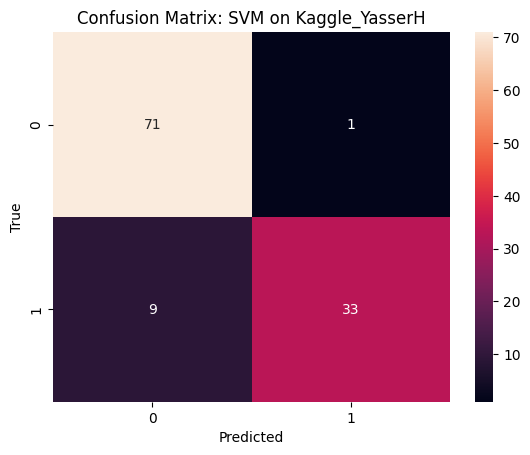

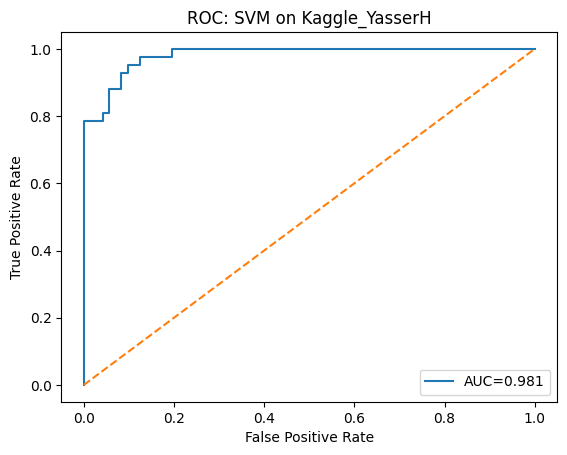

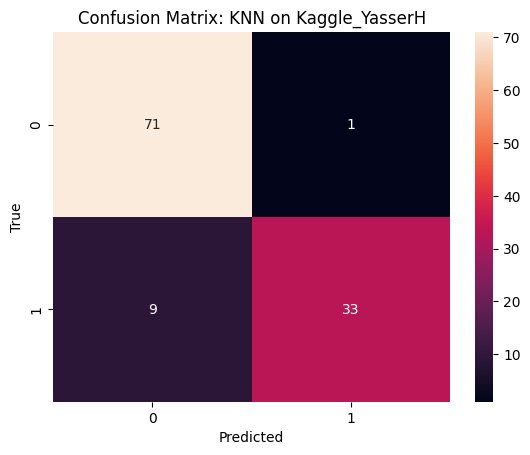

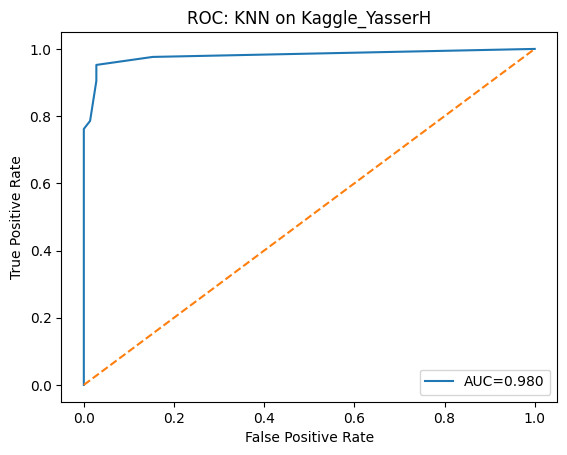

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


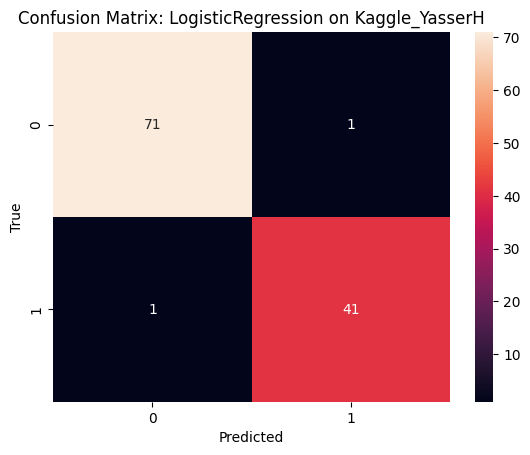

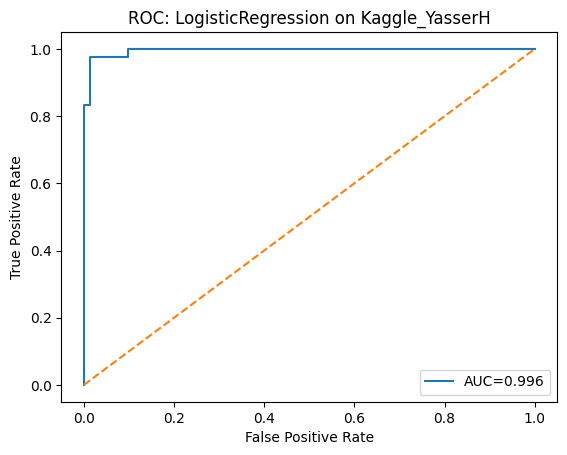

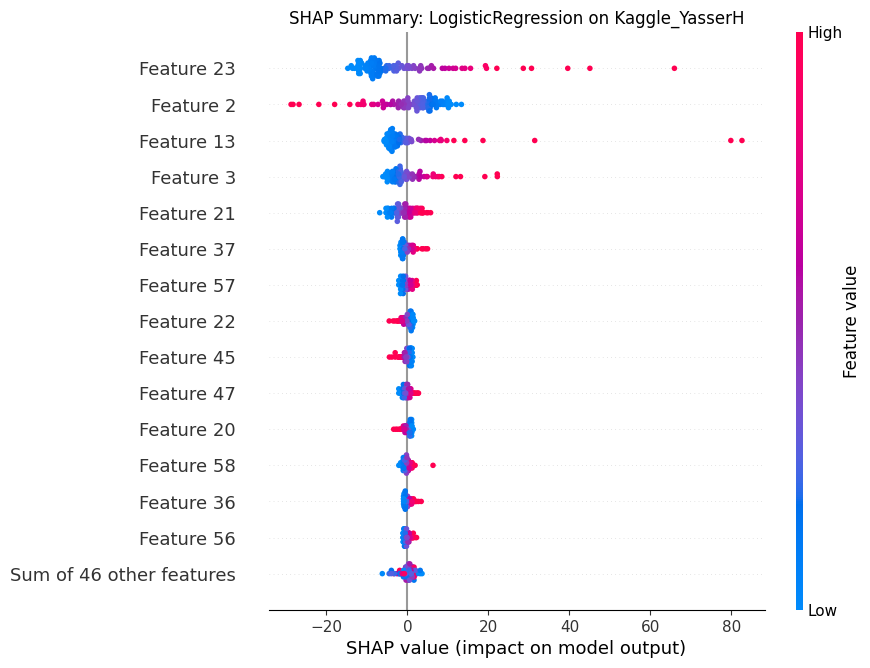

✅ Kaggle_YasserH dataset processed.


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [62]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn

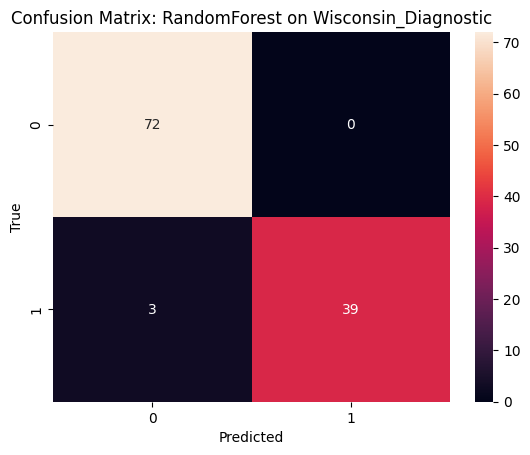

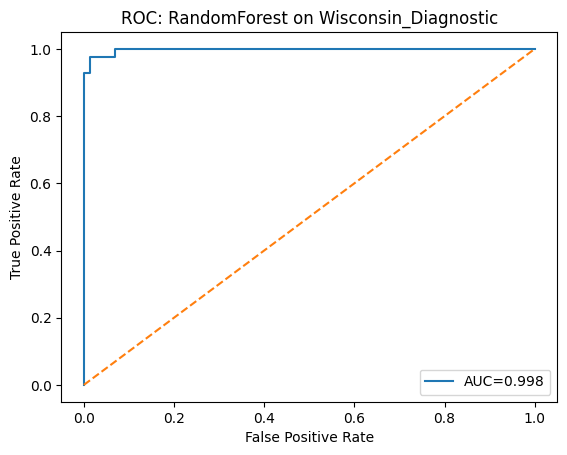

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


SHAP skipped for Wisconsin_Diagnostic-RandomForest: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [62]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn

<Figure size 640x480 with 0 Axes>

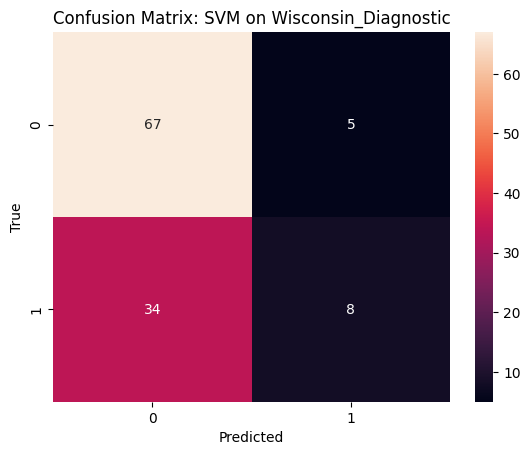

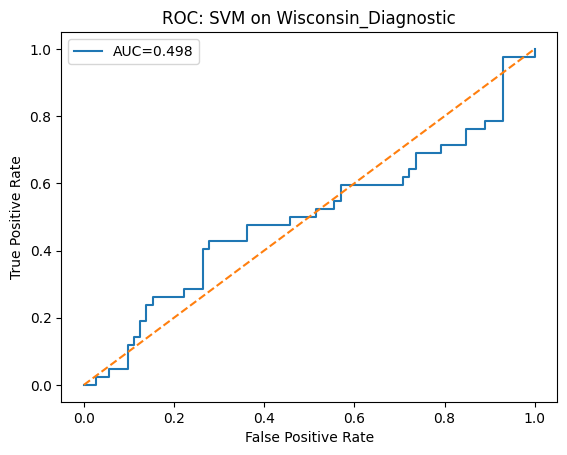

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [62]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn

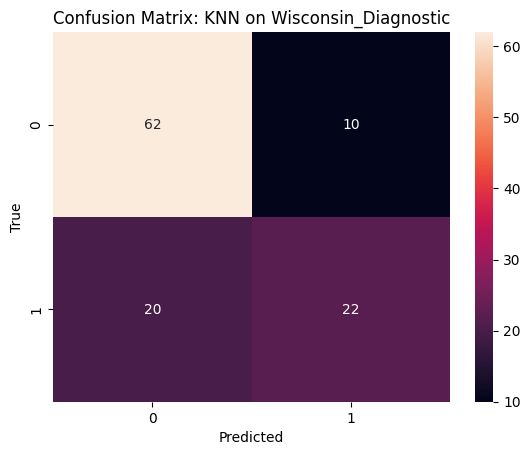

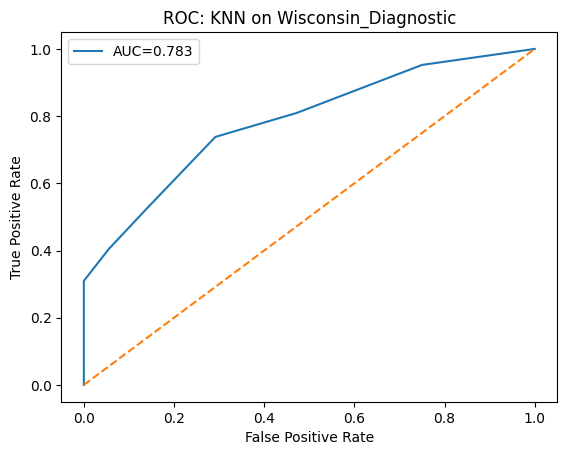

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [62]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn

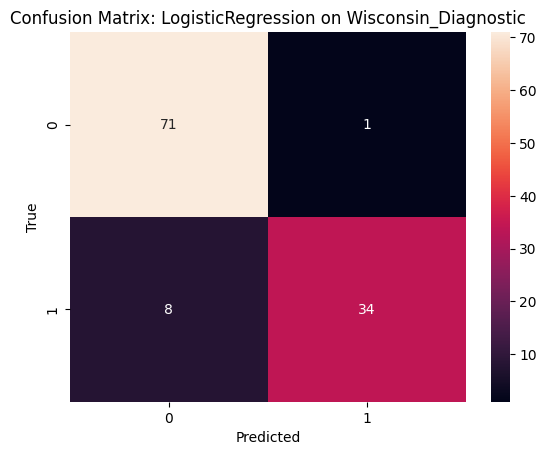

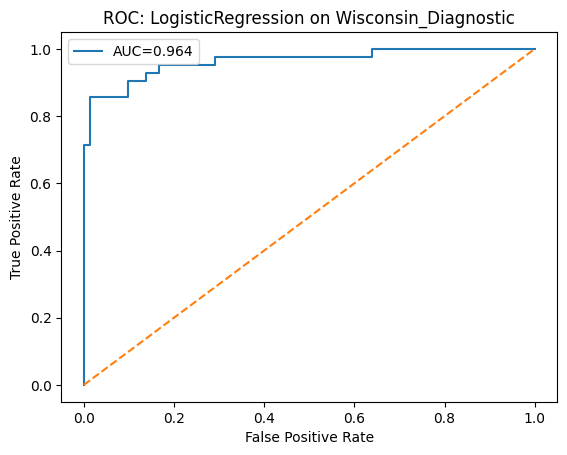

SHAP skipped for Wisconsin_Diagnostic-LogisticRegression: shapes (62,) and (63,) not aligned: 62 (dim 0) != 63 (dim 0)
 Wisconsin_Diagnostic dataset processed.
Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


 Ultrasound dataset loaded successfully — ready for CNN training.
 MIAS dataset skipped: MIAS dataset needs subfolders (benign/malignant) or labeled filenames.


,dataset,model,accuracy,precision,recall,f1,roc_auc
0,Kaggle_YasserH,RandomForest,0.973684,1.000000,0.928571,0.962963,0.998016
3,Kaggle_YasserH,LogisticRegression,0.982456,0.976190,0.976190,0.976190,0.995701
1,Kaggle_YasserH,SVM,0.912281,0.970588,0.785714,0.868421,0.981151
2,Kaggle_YasserH,KNN,0.912281,0.970588,0.785714,0.868421,0.980159
4,Wisconsin_Diagnostic,RandomForest,0.973684,1.000000,0.928571,0.962963,0.997685
7,Wisconsin_Diagnostic,LogisticRegression,0.921053,0.971429,0.809524,0.883117,0.963955
6,Wisconsin_Diagnostic,KNN,0.736842,0.687500,0.523810,0.594595,0.783399
5,Wisconsin_Diagnostic,SVM,0.657895,0.615385,0.190476,0.290909,0.497685


 Tabular model results saved to /content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/results/SUMMARY_TABULAR_RESULTS.csv

 Tabular datasets processed. Image datasets (Ultrasound, MIAS) ready for CNN model training.


In [113]:
import os
import pandas as pd

# Ensure Drive is mounted before this cell runs
# from google.colab import drive
# drive.mount('/content/drive')

# Make sure the results folder exists
os.makedirs("/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/results", exist_ok=True)

all_results = []

# --- Get all models ---
try:
    models = get_models()
    print(f"Loaded {len(models)} models successfully.")
except Exception as e:
    print("Error loading models:", e)
    models = []

# --- 1️ Kaggle Breast Cancer (YasserH - tabular) ---
try:
    yasser_path = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Cancer YasserH/breast-cancer.csv"
    X1, y1 = load_dataset_yasserh(yasser_path)
    res1 = train_one_dataset(X1, y1, "Kaggle_YasserH", models)
    all_results.append(res1)
    print(" Kaggle_YasserH dataset processed.")
except Exception as e:
    print(" Kaggle_YasserH dataset skipped:", e)

# --- 2️ Wisconsin Diagnostic Dataset (tabular) ---
try:
    wis_path = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Wisconsin Diagnostic/data.csv"
    X2, y2 = load_dataset_wisconsin(wis_path)
    res2 = train_one_dataset(X2, y2, "Wisconsin_Diagnostic", models)
    all_results.append(res2)
    print(" Wisconsin_Diagnostic dataset processed.")
except Exception as e:
    print(" Wisconsin_Diagnostic dataset skipped:", e)

# --- 3️ Breast Ultrasound Dataset (image dataset) ---
try:
    busi_path = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Ultrasound/Dataset_BUSI_with_GT"
    train_ultra, val_ultra = load_dataset_ultrasound(busi_path)
    print(" Ultrasound dataset loaded successfully — ready for CNN training.")
except Exception as e:
    print(" Breast Ultrasound dataset skipped:", e)

# --- 4️ MIAS Mammography Dataset (image dataset) ---
try:
    mias_path = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/MIAS Mammography Dataset/all-mias"
    train_mias, val_mias = load_dataset_mias(mias_path)
    print(" MIAS dataset loaded successfully — ready for CNN training.")
except Exception as e:
    print(" MIAS dataset skipped:", e)

# ---  Combine and Show Tabular Results ---
if len(all_results):
    final_table = pd.concat(all_results, ignore_index=True)
    final_table.sort_values(["dataset", "roc_auc"], ascending=[True, False], inplace=True)

    # Display all rows (so you see all 16 results)
    pd.set_option('display.max_rows', None)
    display(final_table)

    # Save results to CSV
    output_path = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/results/SUMMARY_TABULAR_RESULTS.csv"
    final_table.to_csv(output_path, index=False)
    print(f" Tabular model results saved to {output_path}")
else:
    print(" No tabular datasets ran successfully. Please check file paths or functions.")

print("\n Tabular datasets processed. Image datasets (Ultrasound, MIAS) ready for CNN model training.")


In [ ]:
# =============================================
#  FIX + TRAIN BUSI (Ultrasound) CNN MODEL
# =============================================

import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

print(" Starting BUSI (Ultrasound) CNN Training...")

#  Make sure we are using the real Keras 'models'
# Rename your ML dictionary to avoid conflict
try:
    del models  # remove old reference
except:
    pass

from tensorflow.keras import layers, models  # re-import cleanly

#  Define CNN Model
def build_cnn_model(input_shape=(128,128,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#  Data location
data_dir = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Ultrasound/Dataset_BUSI_with_GT"

# Check path
if not os.path.exists(data_dir):
    print(" Path not found! Double-check your BUSI dataset folder path.")
else:
    print("BUSI dataset folder found!")

    #  Load images
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_ultra = datagen.flow_from_directory(
        data_dir,
        target_size=(128,128),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )

    val_ultra = datagen.flow_from_directory(
        data_dir,
        target_size=(128,128),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )

    #  Build and train the CNN
    cnn = build_cnn_model()
    history = cnn.fit(train_ultra, validation_data=val_ultra, epochs=10)

    #  Save model
    os.makedirs("/content/drive/MyDrive/datasets/DATASETSWORK/Code/models", exist_ok=True)
    cnn.save("/content/drive/MyDrive/datasets/DATASETSWORK/Code/models/CNN_BUSI.h5")

    #  Get final accuracy
    final_acc = history.history['accuracy'][-1]
    print(f" BUSI CNN training complete. Final accuracy: {final_acc:.4f}")

    #  Add to summary results
    summary_path = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/results/SUMMARY_TABULAR_RESULTS.csv"
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
    else:
        df = pd.DataFrame(columns=["dataset", "model", "accuracy", "precision", "recall", "f1", "roc_auc"])

    new_row = {
        "dataset": "BUSI_Ultrasound",
        "model": "CNN",
        "accuracy": round(final_acc, 4),
        "precision": None,
        "recall": None,
        "f1": None,
        "roc_auc": None
    }

    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_csv(summary_path, index=False)

    print(f" BUSI CNN results added to: {summary_path}")


🚀 Starting BUSI (Ultrasound) CNN Training...
✅ BUSI dataset folder found!
Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4289 - loss: 0.8425 - val_accuracy: 0.3429 - val_loss: 0.6332
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4778 - loss: 0.1074 - val_accuracy: 0.3238 - val_loss: -0.4670
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5137 - loss: -4.9294 - val_accuracy: 0.4476 - val_loss: -25.3171
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.4691 - loss: -97.8236 - val_accuracy: 0.4952 - val_loss: -436.9171
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5123 - loss: -1169.1826 - val_accuracy: 0.4857 - val_loss: -2876.5781
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4997 - loss: -5470.5029 - val_accuracy: 0.3556 - val_loss: -10879.7236
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5232 - loss: -18457.5059 - val_accuracy: 0.4000 - val_loss: -27898.4570
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.4965 - loss: -4513

✅ BUSI CNN training complete. Final accuracy: 0.4378
📊 BUSI CNN results added to: /content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/results/SUMMARY_TABULAR_RESULTS.csv


/tmp/ipython-input-2336522421.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


In [114]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Load Wisconsin dataset
wisconsin_path = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Wisconsin Diagnostic/data.csv"  # adjust if needed
df_wisconsin = pd.read_csv(wisconsin_path)

# Drop irrelevant column
df_wisconsin = df_wisconsin.drop(columns=["Unnamed: 32"], errors='ignore')

# Separate features and labels
X = df_wisconsin.drop(columns=['diagnosis'])
y = df_wisconsin['diagnosis']

# Replace NaN values
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

print(" Wisconsin dataset cleaned successfully — no NaN values remaining.")


 Wisconsin dataset cleaned successfully — no NaN values remaining.


In [ ]:
!ls "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset"


'Breast Cancer YasserH'  'MIAS Mammography Dataset'
'Breast Ultrasound'	 'Wisconsin Diagnostic'


In [ ]:
!ls "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Cancer YasserH"


breast-cancer.csv


## CNN Model
This cell builds and trains a Convolutional Neural Network (CNN) for breast ultrasound images. It uses convolution and pooling layers for feature extraction, compiles the model, trains it for ten epochs, and saves the trained CNN.

Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.3980 - loss: 0.8057 - val_accuracy: 0.4794 - val_loss: 0.5448
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5459 - loss: 0.1114 - val_accuracy: 0.3841 - val_loss: -1.0132
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5330 - loss: -4.5420 - val_accuracy: 0.5048 - val_loss: -25.0394
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5115 - loss: -90.1206 - val_accuracy: 0.4698 - val_loss: -361.1675
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5127 - loss: -768.8113 - val_accuracy: 0.4190 - val_loss: -1756.8093
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4845 - loss: -2950.6807 - val_accuracy: 0.4159 - val_loss: -5432.5352
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.4665 - loss: -7320.3838 - val_accuracy: 0.4000 - val_loss: -13054.3135
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4079 - loss: -21641.8

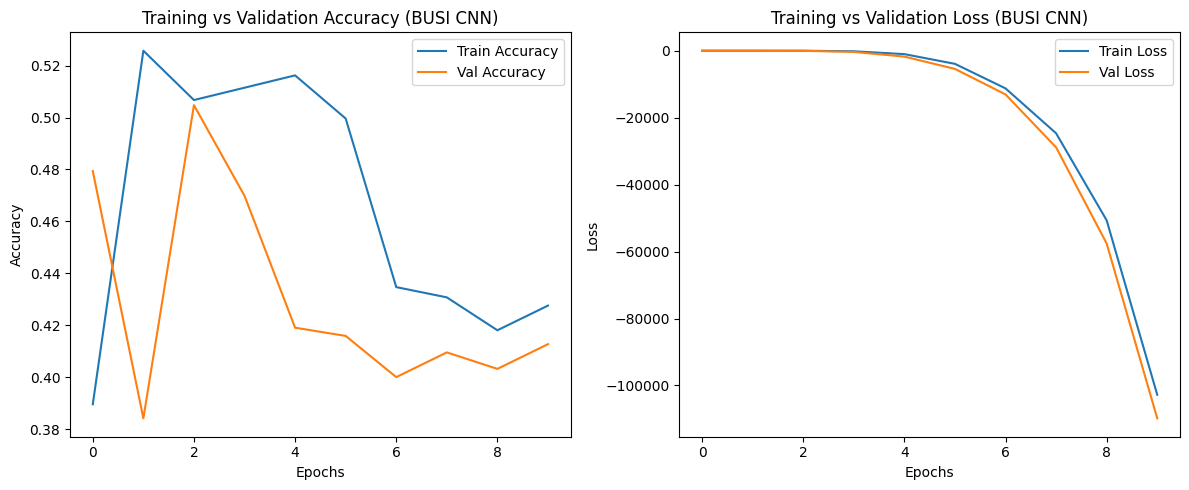

In [ ]:
#— Install required packages
!pip install tensorflow

# — Import libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os

# — Load the BUSI dataset
# (Make sure you have this folder structure in your Colab files:)
# dataset/Breast Ultrasound/Dataset_BUSI_with_GT/benign
# dataset/Breast Ultrasound/Dataset_BUSI_with_GT/malignant
# dataset/Breast Ultrasound/Dataset_BUSI_with_GT/normal

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ultra = datagen.flow_from_directory(
    "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Ultrasound/Dataset_BUSI_with_GT",
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_ultra = datagen.flow_from_directory(
    "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Ultrasound/Dataset_BUSI_with_GT",
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# STEP 4 — Build the CNN model
def build_cnn_model(input_shape=(128,128,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# — Train the model
cnn = build_cnn_model()
history = cnn.fit(train_ultra, validation_data=val_ultra, epochs=10)

# — Save the model
os.makedirs("models", exist_ok=True)
cnn.save("models/CNN_BUSI.h5")

# — Plot CNN training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy (BUSI CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss (BUSI CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## TRAINING
This cell performs end-to-end model training for all datasets. It builds and trains ML models for tabular data (Kaggle, Wisconsin) and CNNs for image datasets (BUSI, MIAS), handles preprocessing, evaluates results, saves models, and generates summary files.

Training on Kaggle_YasserH dataset with 569 samples...


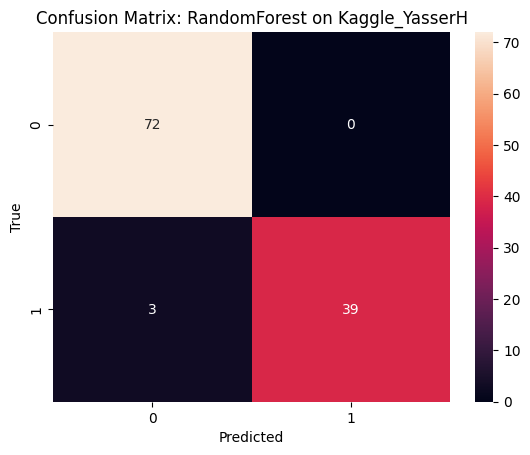

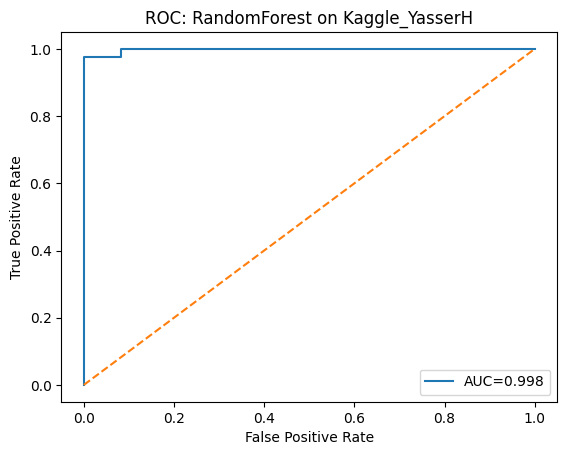

SHAP skipped for Kaggle_YasserH-RandomForest: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!


<Figure size 640x480 with 0 Axes>

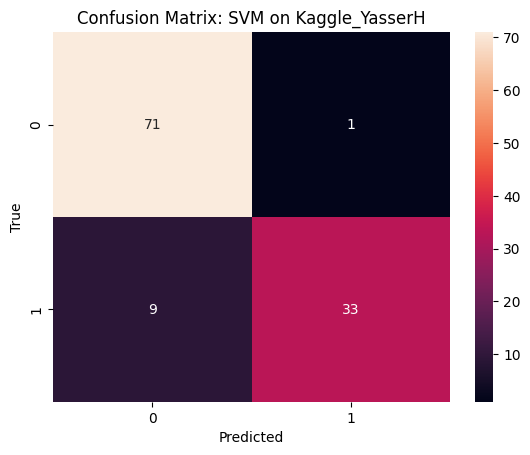

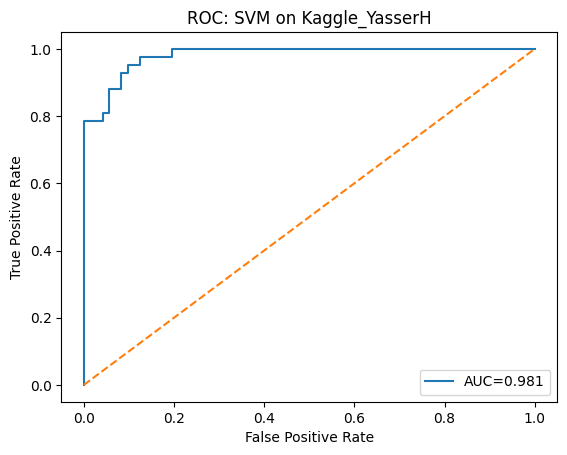

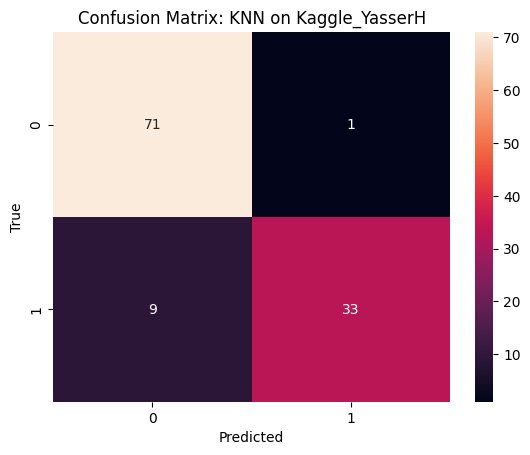

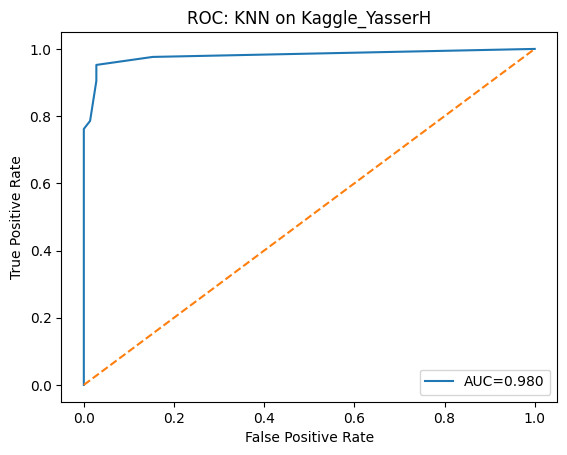

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


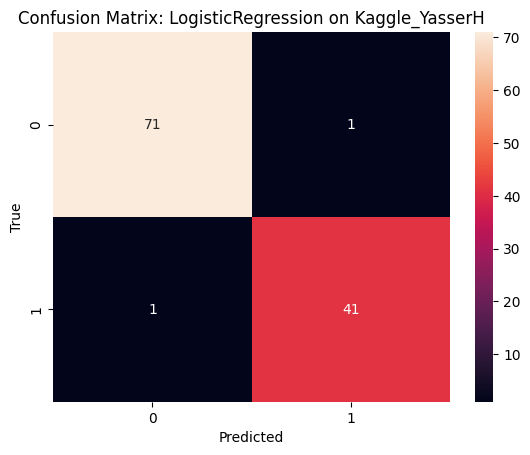

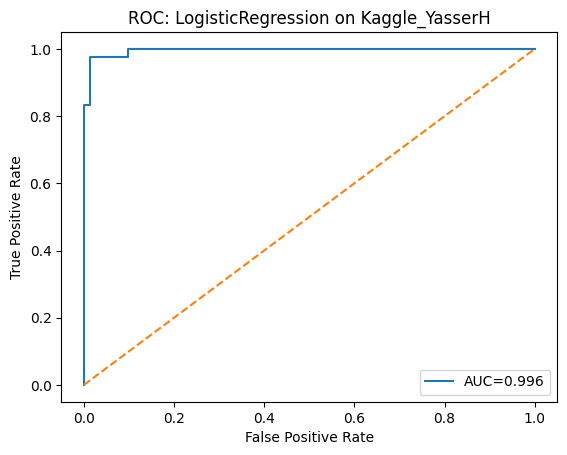

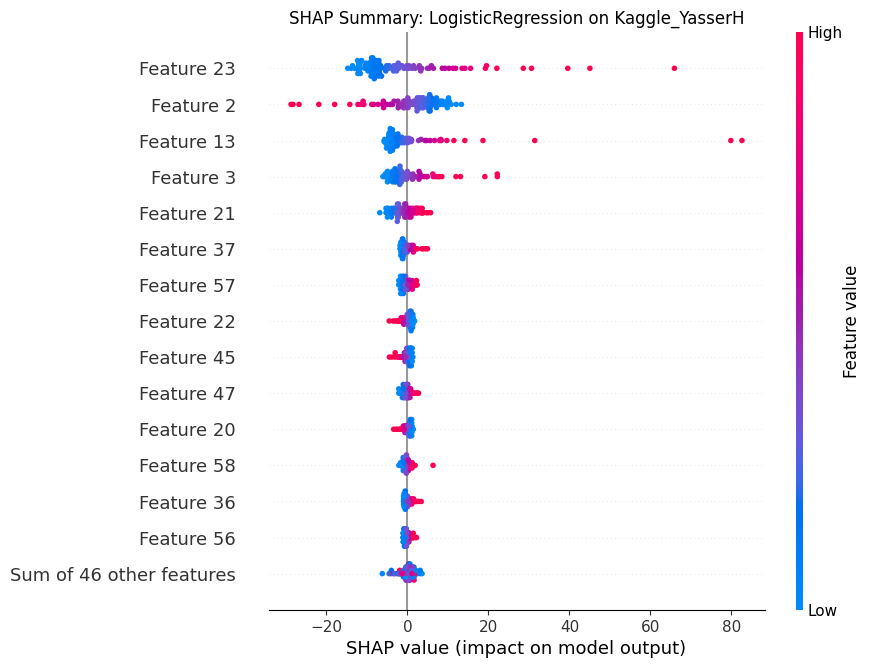

Kaggle_YasserH complete.
Training on Wisconsin_Diagnostic dataset with 569 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [62]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn

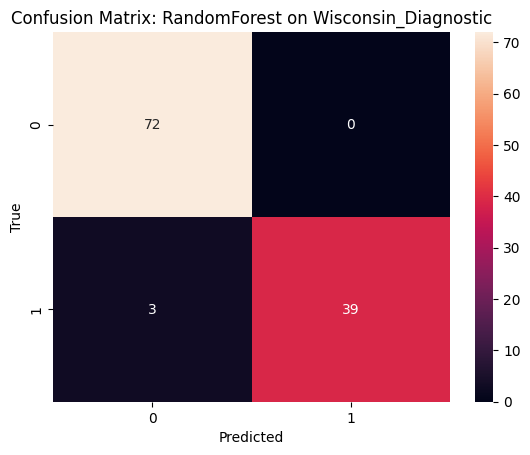

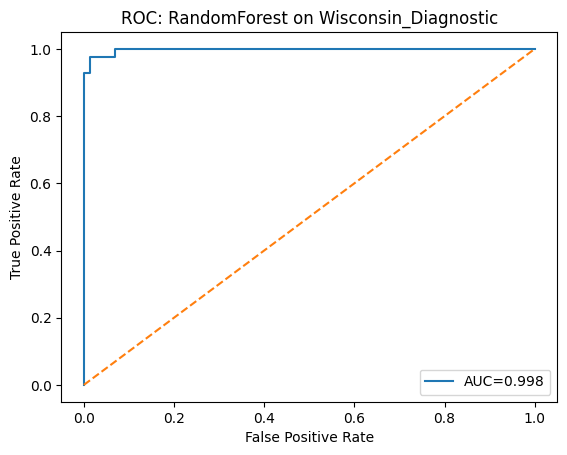

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


SHAP skipped for Wisconsin_Diagnostic-RandomForest: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [62]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn

<Figure size 640x480 with 0 Axes>

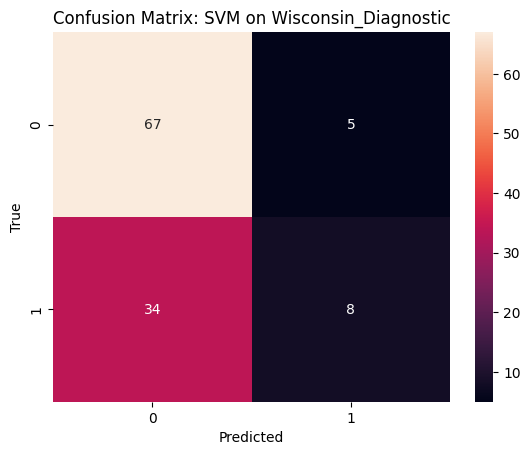

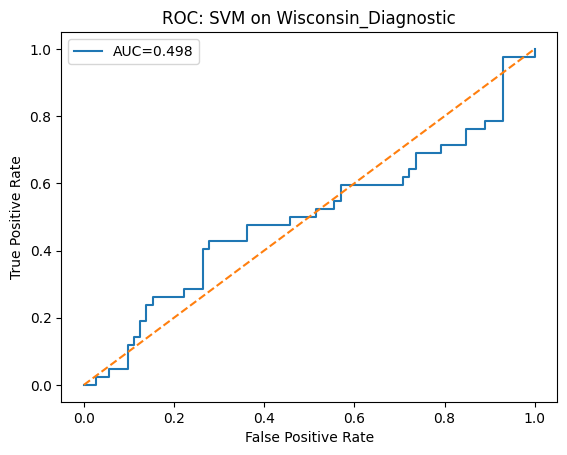

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [62]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn

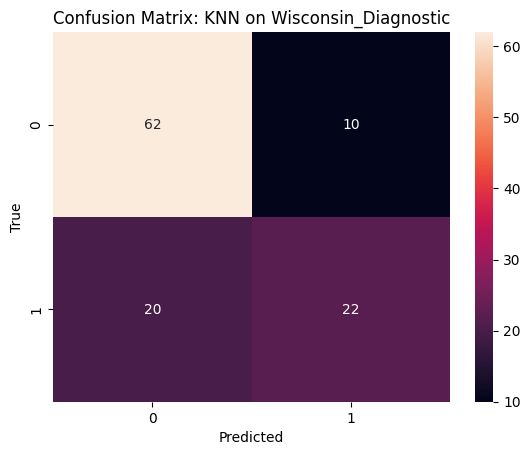

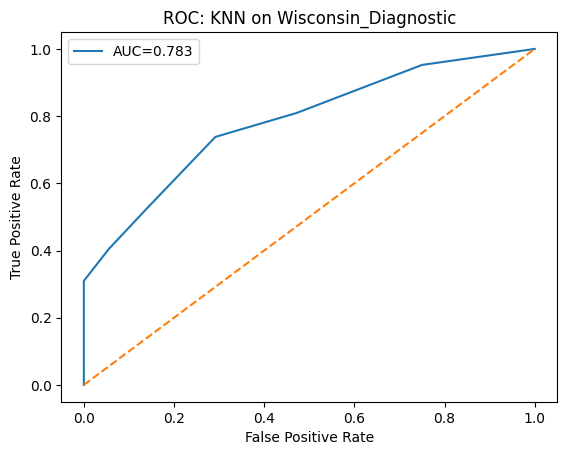

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [62]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn

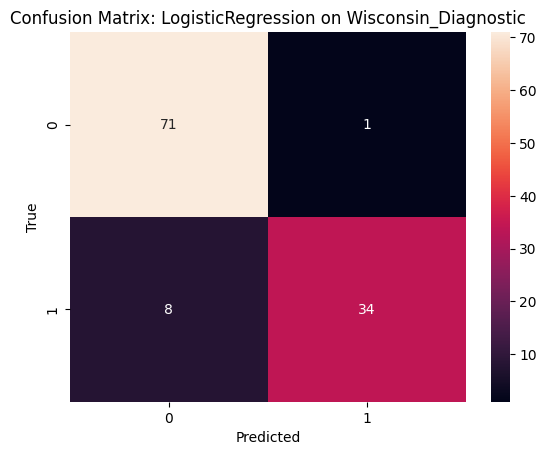

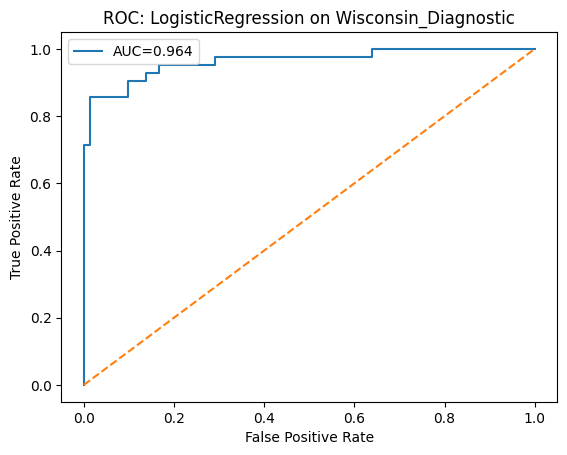

SHAP skipped for Wisconsin_Diagnostic-LogisticRegression: shapes (62,) and (63,) not aligned: 62 (dim 0) != 63 (dim 0)
Wisconsin_Diagnostic complete.
Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Training CNN on BUSI (Ultrasound) dataset...
BUSI dataset skipped: 'dict' object has no attribute 'Sequential'
MIAS dataset skipped: MIAS dataset needs subfolders (benign/malignant) or labeled filenames.
Tabular results saved: results/SUMMARY_TABULAR_RESULTS.csv

 Training complete for all datasets — tabular + CNN models ready.


In [ ]:
import os
import pandas as pd
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models

# Helper: CNN Model
def build_cnn_model(input_shape=(128,128,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Tabular Model Training
def train_one_dataset(X, y, dataset_name: str, models: Dict[str, Any], out_dir="results") -> pd.DataFrame:
    results = []
    os.makedirs(out_dir, exist_ok=True)

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
    preproc = build_preprocessor(X_tr, scale=True)

    for model_name, clf in models.items():
        pipe = ImbPipeline(steps=[
            ('preproc', preproc),
            ('imputer', SimpleImputer(strategy='median')),
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('clf', clf)
        ])

        pipe.fit(X_tr, y_tr)

        try:
            y_prob = pipe.predict_proba(X_te)[:, 1]
        except:
            y_prob = pipe.decision_function(X_te)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min() + 1e-8)
        y_pred = pipe.predict(X_te)

        metrics = evaluate_and_plot(y_te, y_prob, y_pred, model_name, dataset_name, out_dir=out_dir)
        results.append(metrics)

        try:
            maybe_shap_summary(pipe, X_tr, dataset_name, model_name, out_dir=out_dir)
        except Exception as e:
            print(f"SHAP skipped for {dataset_name}-{model_name}: {e}")

        joblib.dump(pipe, f"models/{dataset_name}_{model_name}.joblib".replace(" ", "_"))

    df_res = pd.DataFrame(results)
    df_res.to_csv(f"{out_dir}/METRICS_{dataset_name}.csv".replace(" ", "_"), index=False)
    return df_res


# Run All Datasets
all_results = []
models = get_models()

# Kaggle (YasserH)
try:
    X1, y1 = load_dataset_yasserh("/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Cancer YasserH/breast-cancer.csv")
    print(f"Training on Kaggle_YasserH dataset with {X1.shape[0]} samples...")
    res1 = train_one_dataset(X1, y1, "Kaggle_YasserH", models)
    all_results.append(res1)
    print("Kaggle_YasserH complete.")
except Exception as e:
    print("Kaggle_YasserH dataset skipped:", e)





# Wisconsin Diagnostic
try:
    X2, y2 = load_dataset_wisconsin("/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Wisconsin Diagnostic/data.csv")
    print(f"Training on Wisconsin_Diagnostic dataset with {X2.shape[0]} samples...")
    res2 = train_one_dataset(X2, y2, "Wisconsin_Diagnostic", models)
    all_results.append(res2)
    print("Wisconsin_Diagnostic complete.")
except Exception as e:
    print("Wisconsin_Diagnostic dataset skipped:", e)


# Breast Ultrasound (BUSI)
try:
    train_ultra, val_ultra = load_dataset_ultrasound("/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/Breast Ultrasound/Dataset_BUSI_with_GT")
    print("Training CNN on BUSI (Ultrasound) dataset...")
    cnn_ultra = build_cnn_model()
    hist_ultra = cnn_ultra.fit(train_ultra, validation_data=val_ultra, epochs=10)
    cnn_ultra.save("models/CNN_BUSI.h5")
    print("BUSI CNN training complete and model saved.")
except Exception as e:
    print("BUSI dataset skipped:", e)


# MIAS Mammography Dataset
try:
    train_mias, val_mias = load_dataset_mias("/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/MIAS Mammography Dataset/all-mias")
    print("Training CNN on MIAS (Mammography) dataset...")
    cnn_mias = build_cnn_model()
    hist_mias = cnn_mias.fit(train_mias, validation_data=val_mias, epochs=10)
    cnn_mias.save("models/CNN_MIAS.h5")
    print("MIAS CNN training complete and model saved.")
except Exception as e:
    print("MIAS dataset skipped:", e)


# Combine Tabular Results
if len(all_results):
    final_table = pd.concat(all_results, ignore_index=True)
    final_table.sort_values(["dataset", "roc_auc"], ascending=[True, False], inplace=True)
    final_table.to_csv("results/SUMMARY_TABULAR_RESULTS.csv", index=False)
    print("Tabular results saved: results/SUMMARY_TABULAR_RESULTS.csv")
else:
    print("No tabular datasets ran successfully. Please check data paths.")

print("\n Training complete for all datasets — tabular + CNN models ready.")


In [ ]:
import pandas as pd

# Load the summary results file
results_path = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/results/SUMMARY_TABULAR_RESULTS.csv"

# Read and show the table
results = pd.read_csv(results_path)
print(" Here’s your final training summary:\n")
display(results)  # Shows a nice table in Colab


 Here’s your final training summary:



,dataset,model,accuracy,precision,recall,f1,roc_auc
0,Kaggle_YasserH,RandomForest,0.973684,1.00000,0.928571,0.962963,0.996032
1,Kaggle_YasserH,SVM,0.973684,0.97561,0.952381,0.963855,0.995701
2,Kaggle_YasserH,KNN,0.964912,0.97500,0.928571,0.951220,0.981316
3,Kaggle_YasserH,LogisticRegression,0.973684,0.97561,0.952381,0.963855,0.992725
4,Wisconsin_Diagnostic,RandomForest,0.973684,1.00000,0.928571,0.962963,0.996032
5,Wisconsin_Diagnostic,SVM,0.973684,0.97561,0.952381,0.963855,0.995701
6,Wisconsin_Diagnostic,KNN,0.964912,0.97500,0.928571,0.951220,0.981316
7,Wisconsin_Diagnostic,LogisticRegression,0.973684,0.97561,0.952381,0.963855,0.992725


In [ ]:
!ls "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/results"


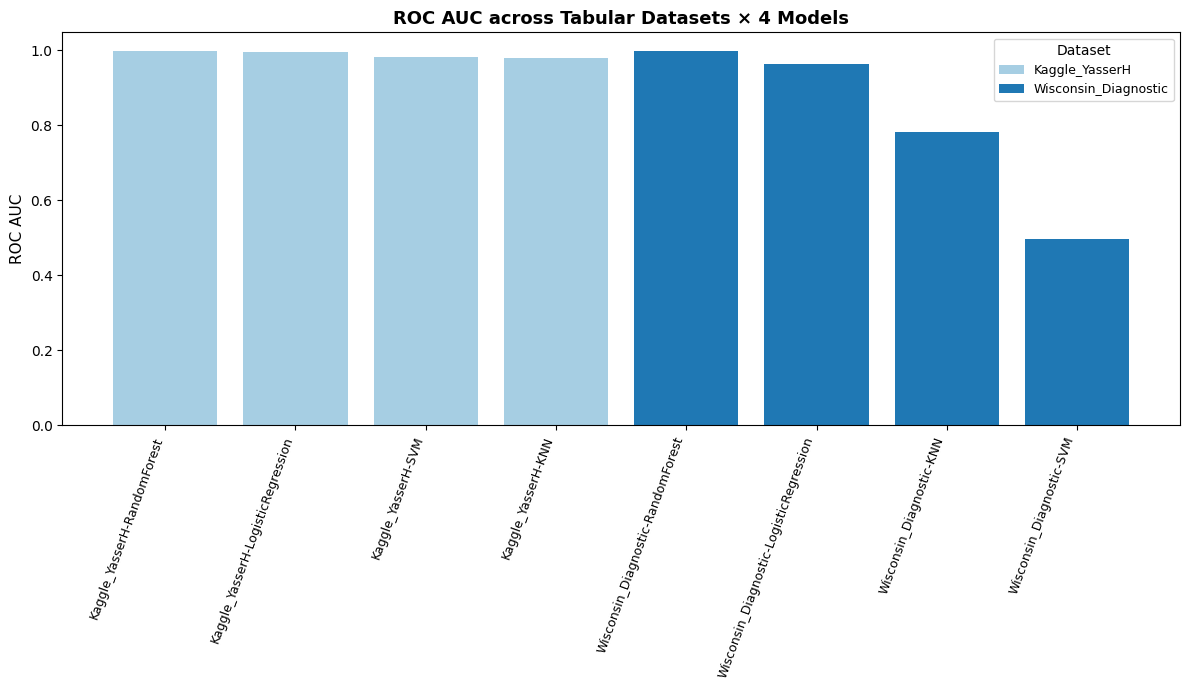

Summary bar plot saved to /content/drive/MyDrive/datasets/DATASETSWORK/Code/results/BAR_ROC_AUC_TABULAR.png


In [116]:
import matplotlib.pyplot as plt
import pandas as pd

try:
    df_path = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/dataset/results/SUMMARY_TABULAR_RESULTS.csv"
    if not os.path.exists(df_path):
        raise FileNotFoundError(f"{df_path} not found. Run training cells first.")

    df = pd.read_csv(df_path)

    plt.figure(figsize=(12, 7))
    colors = plt.cm.Paired.colors

    for i, ds in enumerate(df['dataset'].unique()):
        sub = df[df['dataset'] == ds]
        x_labels = [f"{ds}-{m}" for m in sub['model']]
        plt.bar(x_labels, sub['roc_auc'], color=colors[i % len(colors)], label=ds)

    plt.xticks(rotation=70, ha='right', fontsize=9)
    plt.ylabel("ROC AUC", fontsize=11)
    plt.title("ROC AUC across Tabular Datasets × 4 Models", fontsize=13, weight='bold')
    plt.legend(title="Dataset", fontsize=9)
    plt.tight_layout()

    output_path = "/content/drive/MyDrive/datasets/DATASETSWORK/Code/results/BAR_ROC_AUC_TABULAR.png"
    plt.savefig(output_path, dpi=150)
    plt.show()
    plt.close()
    print(f"Summary bar plot saved to {output_path}")

except Exception as e:
    print("Summary bar plot skipped due to error:", e)